# OSM vs ENTSO validation: comparison for Austria and Macedonia

This notebook is a follow-up notebook to the comparative analysis, where a threefold difference between OSM and ENTSO was observed. This notebook aim to delve deeper into the root causes of this disparity and seek a thorough understanding of the intricacies involved using resource files for Austria (AT) and North Macedonia (MK).

## Data Sources
### OpenStreetMap (OSM)

- OSM is a collaborative mapping platform that provides open-access geographical data. Austria (AT) and North Macedonia (MK) OSM data was used in this analysis, you can download it from the following link:  
  - [Austria](`https://drive.google.com/drive/folders/1zKlh_FKYZlWk0RAQQlhzUdosXa3j-XVN?usp=drive_link`)
  - [North Macedonia](https://drive.google.com/drive/folders/1xOI-0XEixYJvTwP0Hej4q3V-nEKbmKK3?usp=drive_link).

### ENTSOE
- ENTSOE represents a European organization of transmission system operators in the field of electricity. The ENTSOE dataset used here is based on their unofficial ENTSO-E dataset processed by GridKit. To access the ENTSOE data used in this analysis, you can download it from the following link: [ENTSOE Data](https://github.com/PyPSA/pypsa-eur/raw/master/data/entsoegridkit/lines.csv). For more information about the data sources, check [here](https://github.com/PyPSA/pypsa-eur/tree/master/data/entsoegridkit)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pypsa
import json
from shapely import wkt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option("display.max_columns", 1000)

import warnings
warnings.filterwarnings('ignore')

/home/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



ToDo: Automate download process
Download the resources that is needed to run this notebook from the following links
- `https://drive.google.com/drive/folders/1zKlh_FKYZlWk0RAQQlhzUdosXa3j-XVN?usp=drive_link`
- `https://drive.google.com/drive/folders/1xOI-0XEixYJvTwP0Hej4q3V-nEKbmKK3?usp=drive_link`

## Resource Paths

In this notebook, we are working with data resources for Austria (AT) and North Macedonia (MK). We have defined file paths for these resources as follows:

- Austria Resource Path: `at_path = "at_resources"`
- North Macedonia Resource Path: `mk_path = "mk_resources`

These paths point to the directories where relevant data files are located. We will use these paths to access and analyze the data for our comparative analysis.


In [2]:
# folder directory for at and mk

at_path = "at_resources"
mk_path = "mk_resources"

## Base Network Data

In the following code, we are loading data from CSV files representing the base network lines for Austria (AT) and North Macedonia (MK). These files contain information about the network infrastructure for both regions, which is essential for our comparative analysis.

- **Austria Base Network Lines:** Loaded from `at_path/base_network/all_lines_build_network.csv`.
- **North Macedonia Base Network Lines:** Loaded from `mk_path/base_network/all_lines_build_network.csv`.

We will use this data to delve deeper into the comparative analysis between the two regions.


In [3]:
# Read data from CSV files for Austria (AT) and North Macedonia (MK) base network lines.
at_base_network_lines = pd.read_csv(f"{at_path}/base_network/all_lines_build_network.csv")
at_base_network_lines["geometry"] = at_base_network_lines.geometry.apply(wkt.loads)
at_base_network_lines = gpd.GeoDataFrame(at_base_network_lines, geometry="geometry", crs="EPSG:4326")

mk_base_network_lines = pd.read_csv(f"{mk_path}/base_network/all_lines_build_network.csv")
mk_base_network_lines["geometry"] = mk_base_network_lines.geometry.apply(wkt.loads)
mk_base_network_lines = gpd.GeoDataFrame(mk_base_network_lines, geometry="geometry", crs="EPSG:4326")

In [4]:
# Load clean, raw, and country shapefiles for Austria (AT) with GeoPandas.
at_osm_clean_lines = gpd.read_file(f"{at_path}/osm/clean/all_clean_lines.geojson")
at_osm_raw_lines = gpd.read_file(f"{at_path}/osm/raw/all_raw_lines.geojson")
at_country_shape = gpd.read_file(f"{at_path}/shapes/country_shapes.geojson")

# Load clean, raw, and country shapefiles for North Macedonia (MK) with GeoPandas.
mk_osm_clean_lines = gpd.read_file(f"{mk_path}/osm/clean/all_clean_lines.geojson")
mk_osm_raw_lines = gpd.read_file(f"{mk_path}/osm/raw/all_raw_lines.geojson")
mk_country_shape = gpd.read_file(f"{mk_path}/shapes/country_shapes.geojson")


In [5]:
# load entsoe line.csv with pandas dataframe
entsoe_ref_df = pd.read_csv("entsoe_lines_ref.csv", delimiter=",", quotechar="'")

# apply well known text(wkt) to format the geometry column properly
entsoe_ref_df["geometry"] = entsoe_ref_df.geometry.apply(wkt.loads)

# load the data into a geopandas dataframe and format it using a compatible crs
entsoe_ref = gpd.GeoDataFrame(entsoe_ref_df, geometry="geometry", crs="EPSG:3035")

# convert voltage from kV to V
entsoe_ref["voltage"] = entsoe_ref.voltage * 1000

In [6]:
def if_country_in_entsoe(country_df: gpd.GeoDataFrame) -> pd.Series:
    """
    Function checks if country_df is present in enstoe data
    """
    x = entsoe_ref["geometry"].apply(lambda row: row.within(country_df["geometry"][0]))
    return x


def split_col(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Function to split column by ; and explode the values 
    """
    if type(df[col][0]) == str:
        df[col] = df[col].str.split(";")
        df = df.explode(col)

    return df
    
def preprocess_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to split col, 
    filter data, 
    replace nan values, 
    convert voltage column to integer, 
    and rename columns
    """

    if "tags.voltage" in df.columns.tolist():
        df = df.rename(columns={"tags.voltage": "voltage", "Length": "length"})

    df = split_col(df, 'voltage')
    df = df[df['voltage'] != 'low']
    df['voltage'] = df['voltage'].replace(np.nan, 0)
    df['voltage'] = df['voltage'].astype(int)

    return df

def high_voltage_df(df: pd.DataFrame, data_col: str, country_code: str) -> pd.DataFrame :
    """
    Function takes dataframe and data_col to distinguish the data.
    it creates a new dataframe by filtering for high voltage and grouping by sum of length
    """
    if_country_code = f"if_{country_code}"
    df['rebase_voltage'] = df.voltage.apply(lambda row: int(220000) if ((row >= 220000) and (row < 380000)) \
        else (int(380000) if (row >= 380000) else row))

    # check if it is entsoe data before applying filter
    if if_country_code in df.columns.tolist():
        
        df = (df[(df[if_country_code] == True) & (
            df['rebase_voltage'] >= 220000)][["rebase_voltage", "length"]]
                .groupby(["rebase_voltage"])["length"]
                .sum()
                .reset_index())

    else:
        df = (df[df["rebase_voltage"] >= 220000][["rebase_voltage", "length"]]
                .groupby(["rebase_voltage"])["length"]
                .sum()
                .reset_index()
                )

    # create new column with col_name
    df['data'] = data_col

    return df

def create_plot(df: pd.DataFrame, country: str) -> None:
    """
    Function creates a comparison plot for osm_clean, osm_raw and entsoe data
    country: will be used to identify the country plot
    """ 

    plt.figure(figsize=(15, 5))
    sns.barplot(x="rebase_voltage", y="length", hue="data", data=df)
    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country.upper()}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None
    
def geospatial_plot(voltage_level: int, country_code: str):
    """
    Function takes voltage level and plot a geospatial plot based on the voltage_level
    """

    country_code = country_code.lower()

    # Filter for country code
    if country_code == "at":
        country_shape = at_country_shape
        osm_raw_lines = at_osm_raw_lines
        osm_clean_lines = at_osm_clean_lines
        osm_base_network_lines = at_base_network_lines
    elif country_code == "mk":
        country_shape = mk_country_shape
        osm_raw_lines = mk_osm_raw_lines
        osm_clean_lines = mk_osm_clean_lines
        osm_base_network_lines = mk_base_network_lines
    else:
        print("check that country code is either AT or MK")

    ax = country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    osm_raw_lines[osm_raw_lines['rebase_voltage'] == voltage_level].plot(figsize=(15,10), color="red", alpha=0.2, ax=ax, label='raw')
    osm_clean_lines[osm_clean_lines['rebase_voltage'] == voltage_level].plot(figsize=(15,10), color="blue", alpha=0.5, ax=ax, label='clean')
    osm_base_network_lines[osm_base_network_lines['rebase_voltage'] == voltage_level].plot(figsize=(15,10), color="orange", alpha=0.8, ax=ax, label='base_network')

    # to handle empty values in entsoe data in voltage level 220000 in MK data
    if len(entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) & (entsoe_ref['voltage'] == voltage_level)]) is not 0:
        entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) & (entsoe_ref['voltage'] == voltage_level)].plot(figsize=(15,10), color='green', alpha=1.0, ax=ax, label='entsoe')
   
    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()} ({voltage_level}V)")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()

In [7]:
# Determine if Austria (AT) is in the ENTSO-E data.
entsoe_ref["if_at"] = if_country_in_entsoe(at_country_shape)

# Determine if North Macedonia (MK) is in the ENTSO-E data.
entsoe_ref["if_mk"] = if_country_in_entsoe(mk_country_shape)

In [8]:
# Clean the Austria (AT) OSM raw data, addressing non-uniform column names and NaN values.
at_osm_raw_lines = preprocess_raw_data(at_osm_raw_lines)

# Clean the North Macedonia (MK) OSM raw data, addressing non-uniform column names and NaN values.
mk_osm_raw_lines = preprocess_raw_data(mk_osm_raw_lines)

In [9]:
# Filter high-voltage lines for Austria (AT) from different data sources.
df_at_osm_clean_lines = high_voltage_df(at_osm_clean_lines, 'osm_clean', 'at')
df_at_osm_raw_lines = high_voltage_df(at_osm_raw_lines, 'osm_raw', 'at')
df_at_osm_base_network_lines = high_voltage_df(at_base_network_lines, 'osm_base_network', 'at')
df_at_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'at')

# Filter high-voltage lines for North Macedonia (MK) from different data sources.
df_mk_osm_clean_lines = high_voltage_df(mk_osm_clean_lines, 'osm_clean', 'mk')
df_mk_osm_raw_lines = high_voltage_df(mk_osm_raw_lines, 'osm_raw', 'mk')
df_mk_osm_base_network_lines = high_voltage_df(mk_base_network_lines, 'osm_base_network', 'mk')
df_mk_entsoe_lines = high_voltage_df(entsoe_ref, 'entsoe_ref', 'mk')


In [10]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for AT
at_dataframe = pd.concat([
    df_at_osm_raw_lines, 
    df_at_osm_clean_lines,
    df_at_osm_base_network_lines,
    df_at_entsoe_lines], ignore_index=True
    )
    
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for MK
mk_dataframe = pd.concat([
    df_mk_osm_raw_lines, 
    df_mk_osm_clean_lines, 
    df_mk_osm_base_network_lines,
    df_mk_entsoe_lines], ignore_index=True
)

### Geospatial Visualization

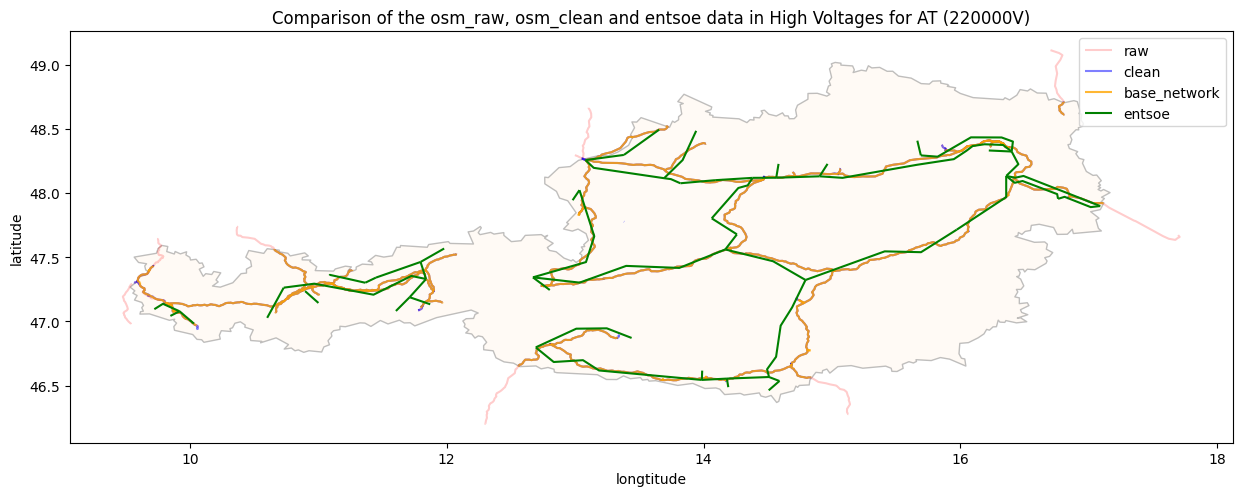

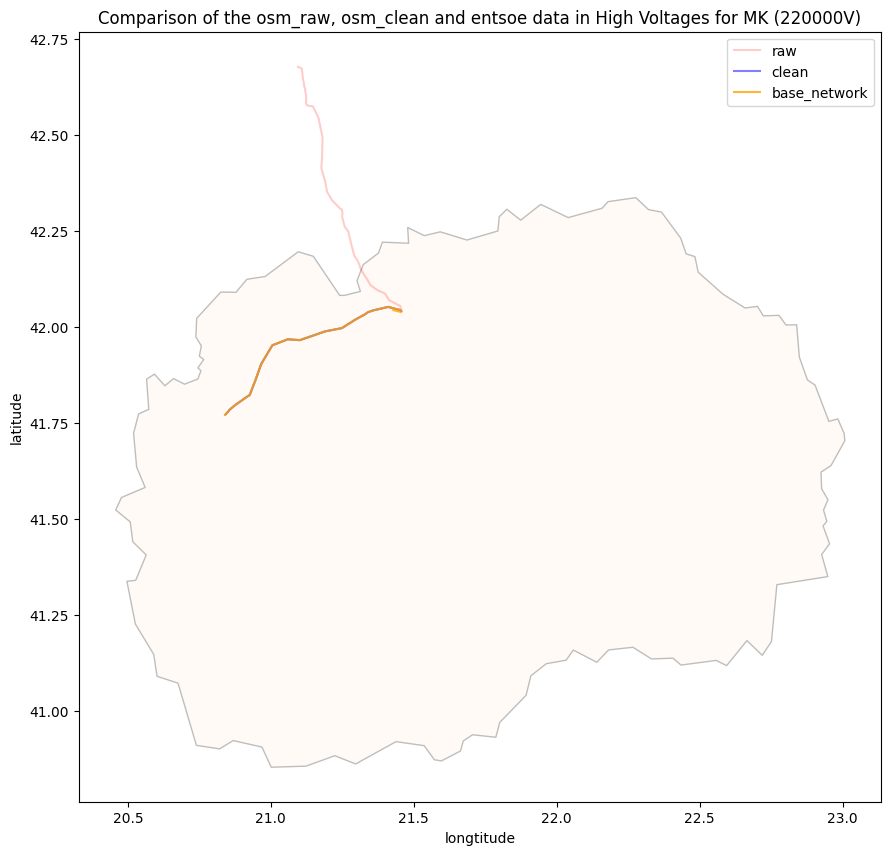

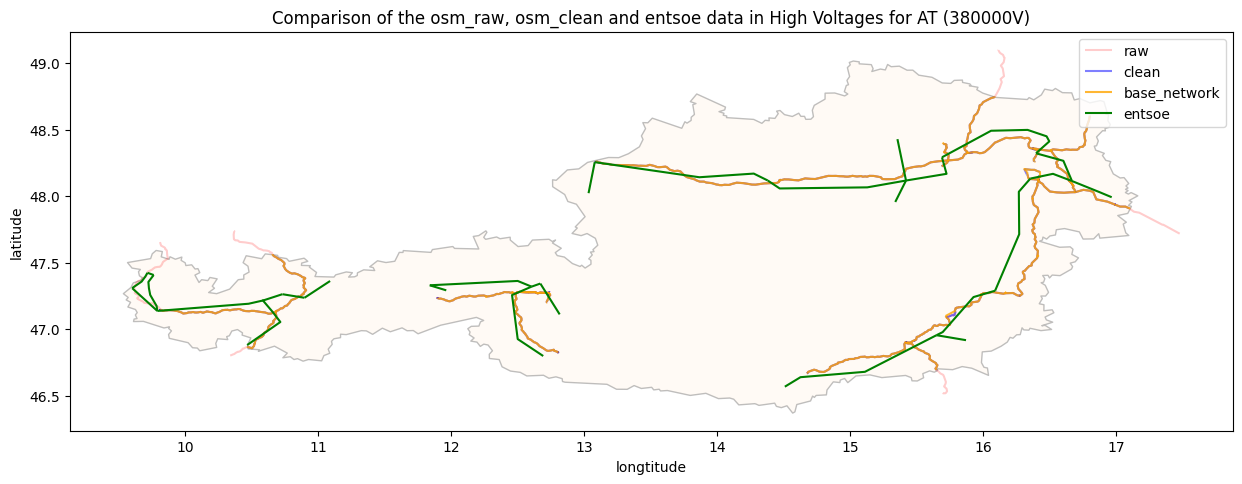

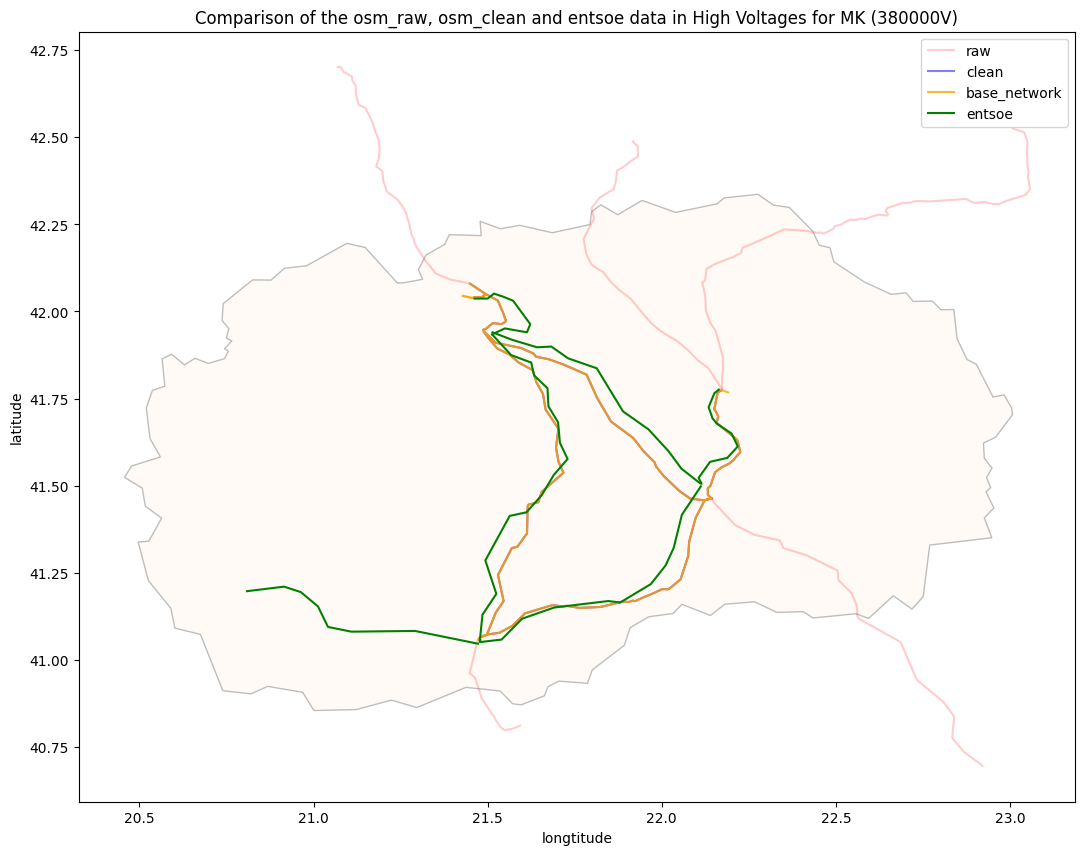

In [11]:
geospatial_plot(220000, "AT")
geospatial_plot(220000, "MK")

geospatial_plot(380000, "AT")
geospatial_plot(380000, "MK")

## Comparison with Barchart

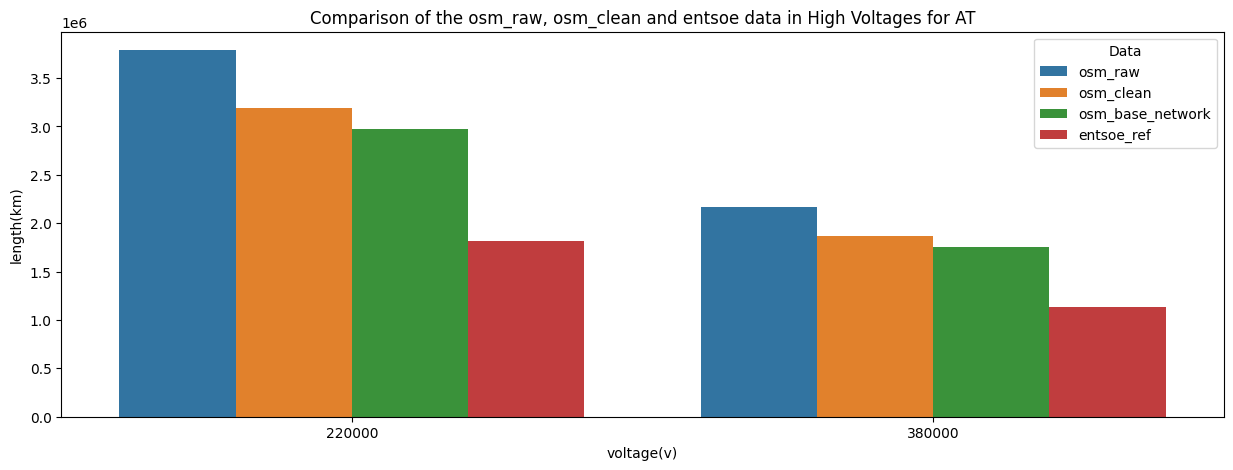

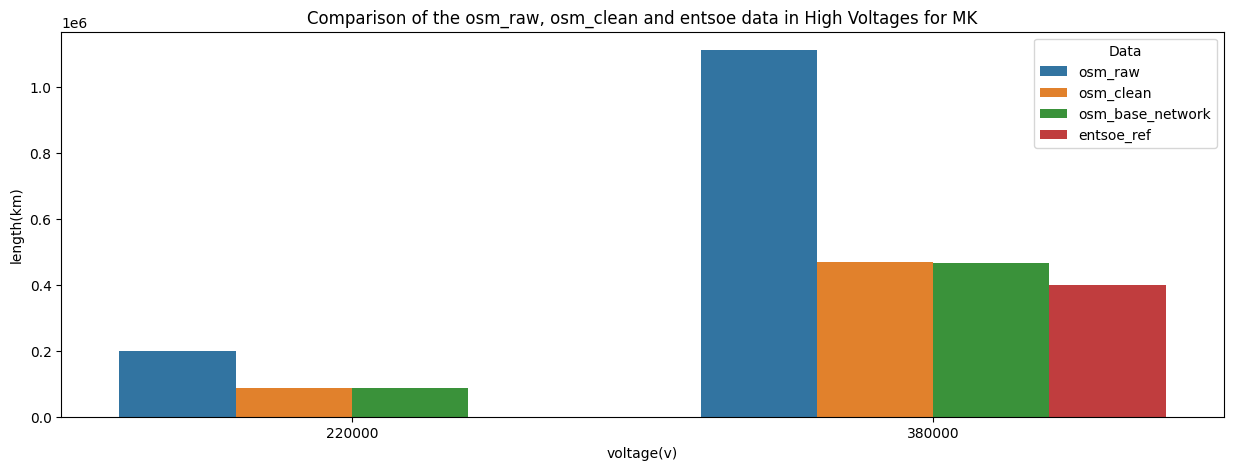

In [12]:
create_plot(at_dataframe, 'at')
create_plot(mk_dataframe, 'mk')

### Table representing sum of length for different voltage levels

In [13]:
at_dataframe.pivot(index='rebase_voltage', columns='data', values='length')

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,1.812981e+06,2.974256e+06,3.193296e+06,3.789003e+06
380000,1.138607e+06,1.753414e+06,1.865833e+06,2.169454e+06


In [14]:
mk_dataframe.pivot(index='rebase_voltage', columns='data', values='length')

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,NaN,87942.816924,87942.816924,1.998913e+05
380000,401388.572228,466749.534204,469160.594075,1.113347e+06


## Section 2 Applying Simplification

The reason for simplification is to examine whether it has a direct impact on the length of the lines. Therefore, simplification is applied to OpenStreetMap (OSM) data and compared with ENTSOE data.

In [15]:
def _apply_simplication(df:pd.DataFrame, tolerance: float, country_code: str, data_col: str):
    """
    Applying simplification, to_crs and high_voltage_df to dataframe with pandas method chaining
    """

    df = df.copy() \
        .assign(geometry=lambda df: df.geometry.simplify(tolerance)) \
        .assign(length=lambda df: df.to_crs(epsg=3857).length) \
        .pipe(process_high_voltage_df, data_col, country_code.lower)
    
    return df

def process_high_voltage_df(df: pd.DataFrame, source: str, country: str):
    """
    Process a DataFrame for high voltage data by applying the 'high_voltage_df' function.
    """
    return df.pipe(high_voltage_df, source, country)

In [16]:
# Define tolerance level for simplification
tolerance = 0.05

In [17]:
# Applying simplification function to preprocess the dataframe with __apply_simplification func

df_at_osm_clean_lines_copy = _apply_simplication(at_osm_clean_lines, tolerance, 'at', 'osm_clean')
df_at_osm_raw_lines_copy = _apply_simplication(at_osm_raw_lines, tolerance, 'at', 'osm_raw')
df_at_osm_base_network_copy = _apply_simplication(at_base_network_lines, tolerance, 'at', 'osm_base_network')

df_mk_osm_clean_lines_copy = _apply_simplication(mk_osm_clean_lines, tolerance, 'mk', 'osm_clean')
df_mk_osm_raw_lines_copy = _apply_simplication(mk_osm_raw_lines, tolerance, 'mk', 'osm_raw')
df_mk_osm_base_network_copy = _apply_simplication(mk_base_network_lines, tolerance, 'mk', 'osm_base_network')


In [18]:
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for AT
at_dataframe_copy = pd.concat([
    df_at_osm_raw_lines_copy, 
    df_at_osm_clean_lines_copy,
    df_at_osm_base_network_copy, 
    df_at_entsoe_lines], ignore_index=True
    )
    
# merge osm_clean, osm_raw and entsoe preprocess data into a single dataframe for MK
mk_dataframe_copy = pd.concat([
    df_mk_osm_raw_lines_copy, 
    df_mk_osm_clean_lines_copy, 
    df_mk_osm_base_network_copy,
    df_mk_entsoe_lines], ignore_index=True
)

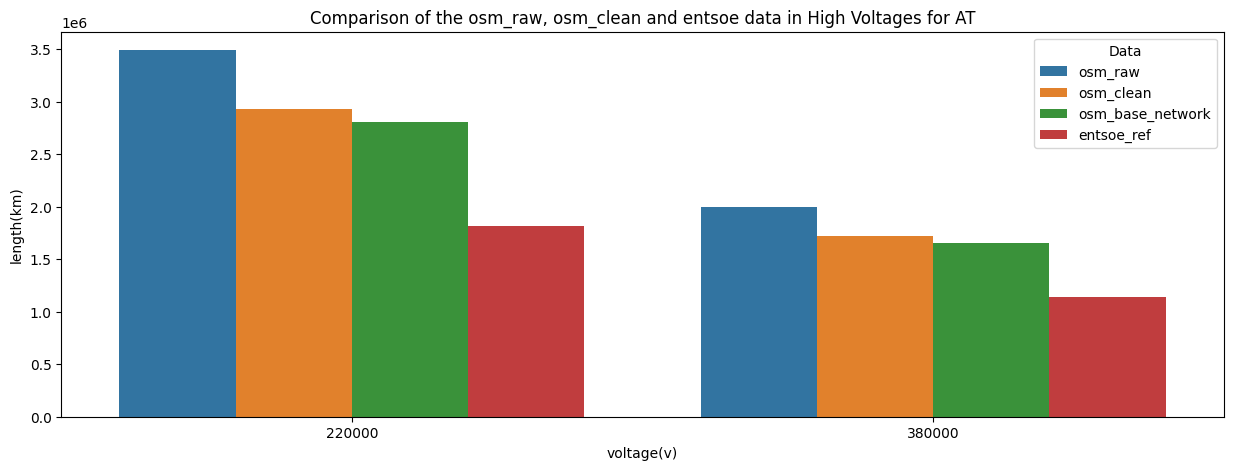

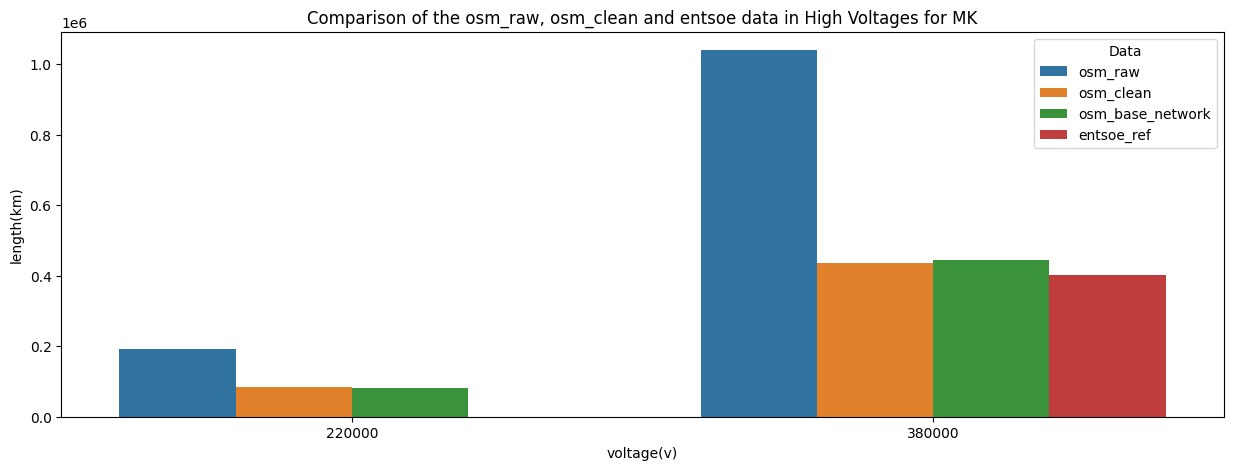

In [19]:
# Create plot using the simplified dataframe

create_plot(at_dataframe_copy, 'at')
create_plot(mk_dataframe_copy, 'mk')

In [20]:
def geospatial_plot_simplified(voltage_level: int, country_code: str, tolerance):
    """
    Function takes voltage level and plot a geospatial plot based on the voltage_level and tolerance level for simplified data
    """
    country_code = country_code.lower()

    # Filter for country code
    if country_code == "at":
        country_shape = at_country_shape
        osm_raw_lines = at_osm_raw_lines
        osm_clean_lines = at_osm_clean_lines
        osm_base_network_lines = at_base_network_lines
    elif country_code == "mk":
        country_shape = mk_country_shape
        osm_raw_lines = mk_osm_raw_lines
        osm_clean_lines = mk_osm_clean_lines
        osm_base_network_lines = mk_base_network_lines
    else:
        print("check that country code is either AT or MK")

    ax = country_shape.plot(edgecolor='grey', alpha=.5, figsize=(15,10),cmap='OrRd')
    osm_raw_lines[osm_raw_lines['rebase_voltage'] == voltage_level].geometry.simplify(tolerance).plot(figsize=(15,10), color="red", alpha=0.2, ax=ax, label='raw')
    osm_clean_lines[osm_clean_lines['rebase_voltage'] == voltage_level].geometry.simplify(tolerance).plot(figsize=(15,10), color="blue", alpha=0.5, ax=ax, label='clean')
    osm_base_network_lines[osm_base_network_lines['rebase_voltage'] == voltage_level].geometry.simplify(tolerance).plot(figsize=(15,10), color="orange", alpha=0.8, ax=ax, label='base_network')

    # to handle empty values in entsoe data in voltage level 220000 in MK data
    if len(entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) & (entsoe_ref['voltage'] == voltage_level)]) is not 0:
        entsoe_ref[(entsoe_ref[f'if_{country_code}'] == True) & (entsoe_ref['voltage'] == voltage_level)].geometry.simplify(tolerance).plot(figsize=(15,10), color='green', alpha=1.0, ax=ax, label='entsoe')
   
    plt.title(f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()} ({voltage_level}V)")
    plt.xlabel("longtitude")
    plt.ylabel("latitude")
    plt.legend()
    plt.show()

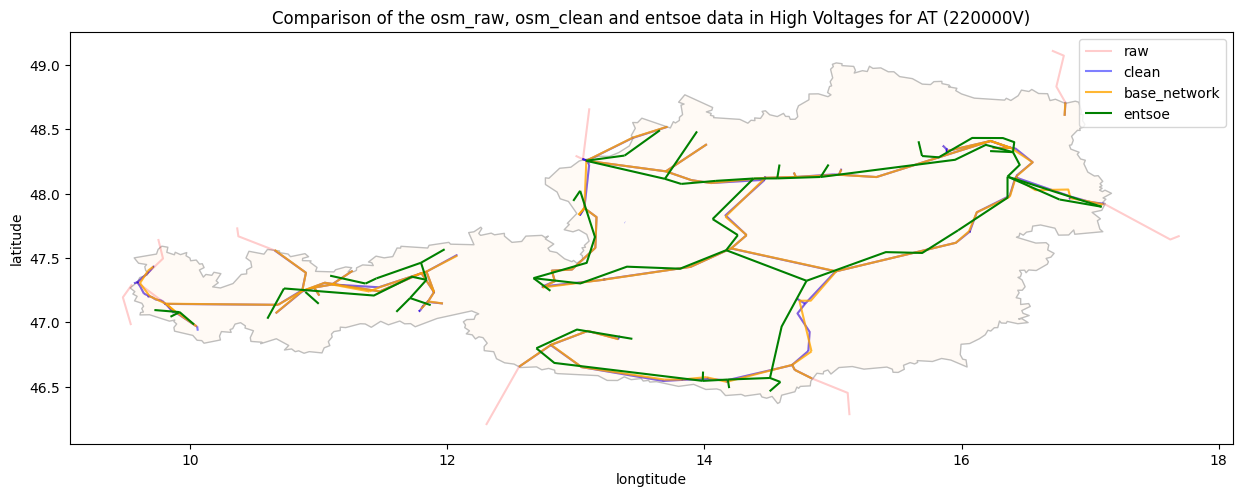

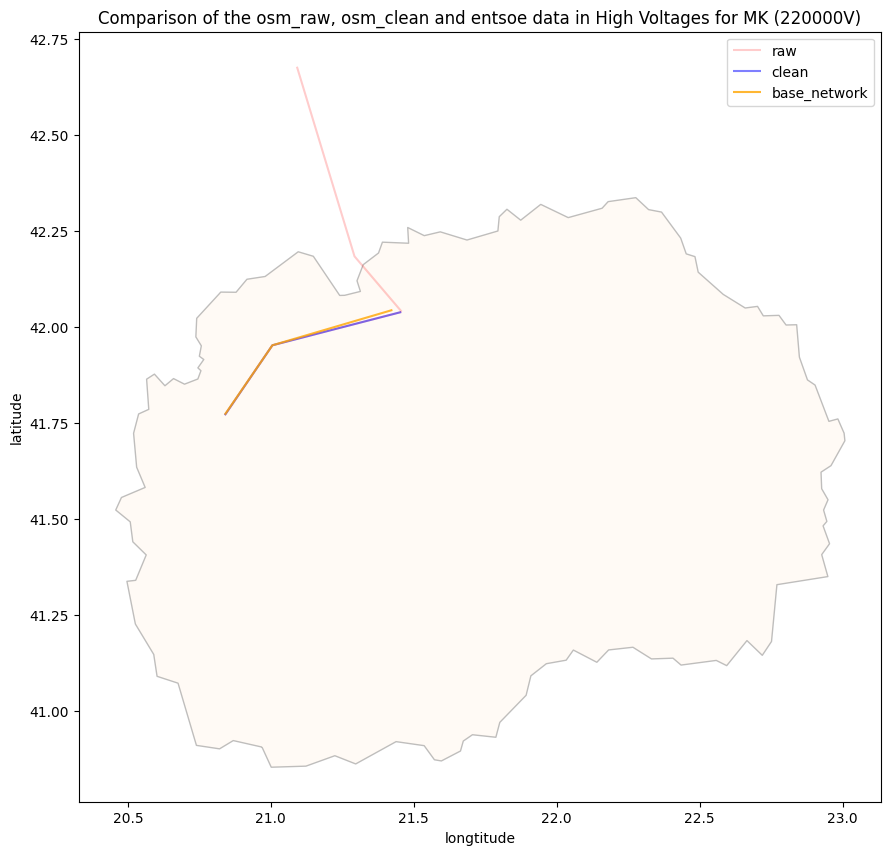

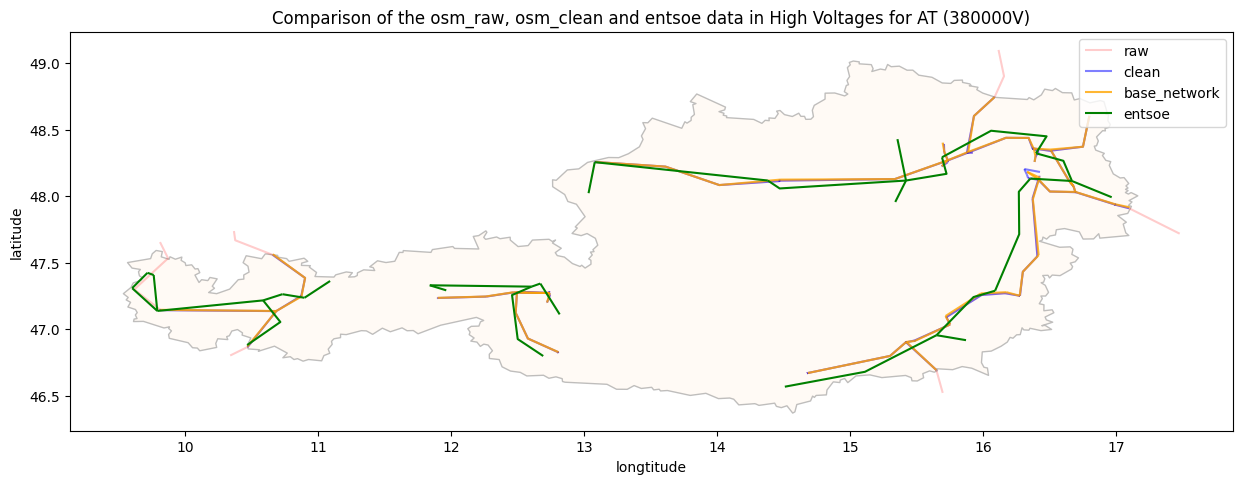

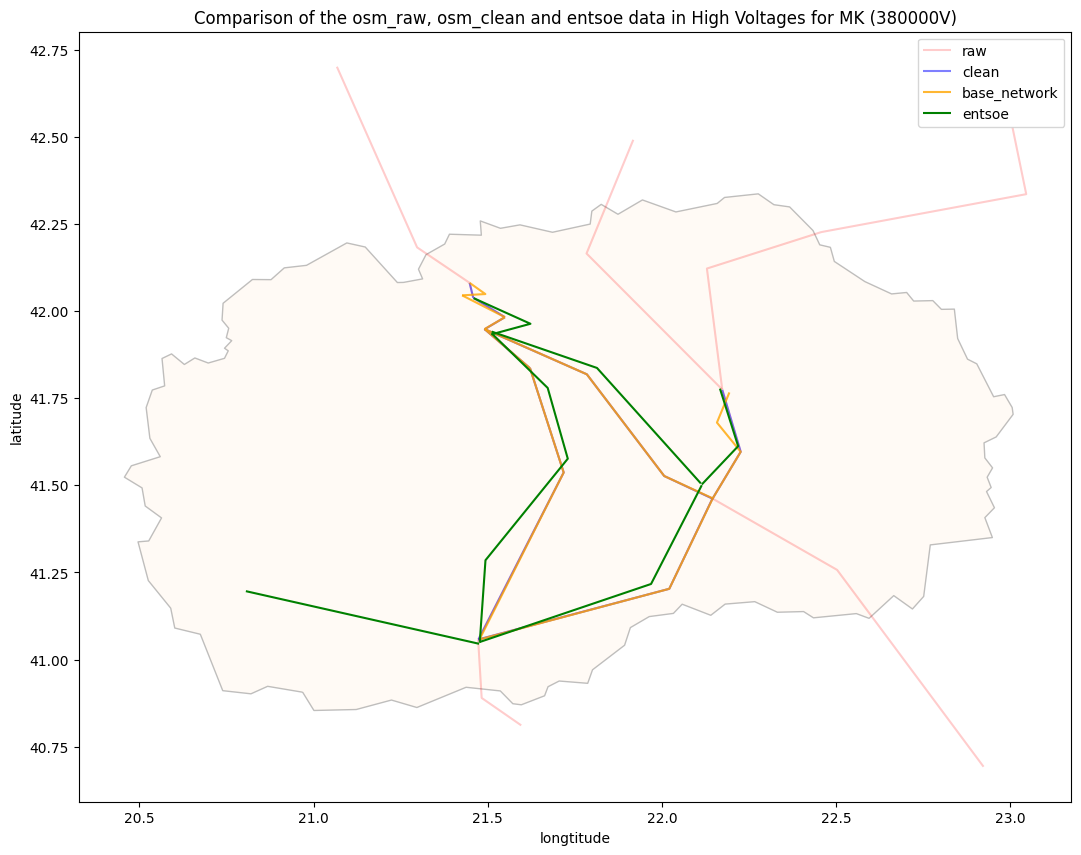

In [21]:
# geospatial plot for different voltage level based on set tolerance level
geospatial_plot_simplified(220000, "at", tolerance)
geospatial_plot_simplified(220000, "mk", tolerance)

geospatial_plot_simplified(380000, "at", tolerance)
geospatial_plot_simplified(380000, "mk", tolerance)

## Simplified vs Non Simplified

This section aims to compare results from the simplified analysis against results from the non-simplified analysis.

In [22]:
def percentage_difference(df: pd.DataFrame, df_copy: pd.DataFrame) -> pd.DataFrame:
    """
    Function takes two dataframe and return the percentage between the dataframes
    """
    numerator = (df.pivot(index='rebase_voltage', columns='data', values='length') - df_copy.pivot(index='rebase_voltage', columns='data', values='length'))
    denominator = (df_copy.pivot(index='rebase_voltage', columns='data', values='length')) * 100
    return numerator/denominator

def simplified_plot(df: pd.DataFrame, country_code: str) -> None:
    """
    Functions plots a comparison plot between simplified data and non_simplified data for osm and entsoe
    """
    plt.figure(figsize=(15, 5))
    sns.barplot(x="rebase_voltage", y="length", hue="data", data=df, palette='Set1')

    plt.xlabel("voltage(v)")
    plt.ylabel("length(km)")
    plt.title(
        f"Comparison of the osm_raw, osm_clean and entsoe data in High Voltages for {country_code.upper()}"
    )
    plt.legend(title="Data", loc="upper right")
    plt.show()

    return None

In [23]:
# percentage difference for MK
percentage_difference(mk_dataframe, mk_dataframe_copy)

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,NaN,0.000801,0.00038,0.000476
380000,0.0,0.000498,0.00079,0.000704


In [24]:
# percentage difference for AT
percentage_difference(at_dataframe, at_dataframe_copy)

data,entsoe_ref,osm_base_network,osm_clean,osm_raw
rebase_voltage,,,,
220000,0.0,0.000593,0.000886,0.000846
380000,0.0,0.000563,0.000822,0.000834


In [25]:
# replacing the columns names before concatenating with the original dataframe

at_dataframe_copy = at_dataframe_copy.replace(
    {"osm_raw": "osm_raw_sim", "osm_clean": "osm_clean_sim", "osm_base_network": "osm_base_network_sim"})
mk_dataframe_copy = mk_dataframe_copy.replace(
    {"osm_raw": "osm_raw_sim", "osm_clean": "osm_clean_sim", "osm_base_network": "osm_base_network_sim"})


In [26]:
# concat the original dataframe with the simplified dataframe

df_at = pd.concat([at_dataframe, at_dataframe_copy])
df_at = df_at.sort_values(['length','data'], ascending=False)

df_mk = pd.concat([mk_dataframe, mk_dataframe_copy])
df_mk = df_mk.sort_values(['length','data'], ascending=False)

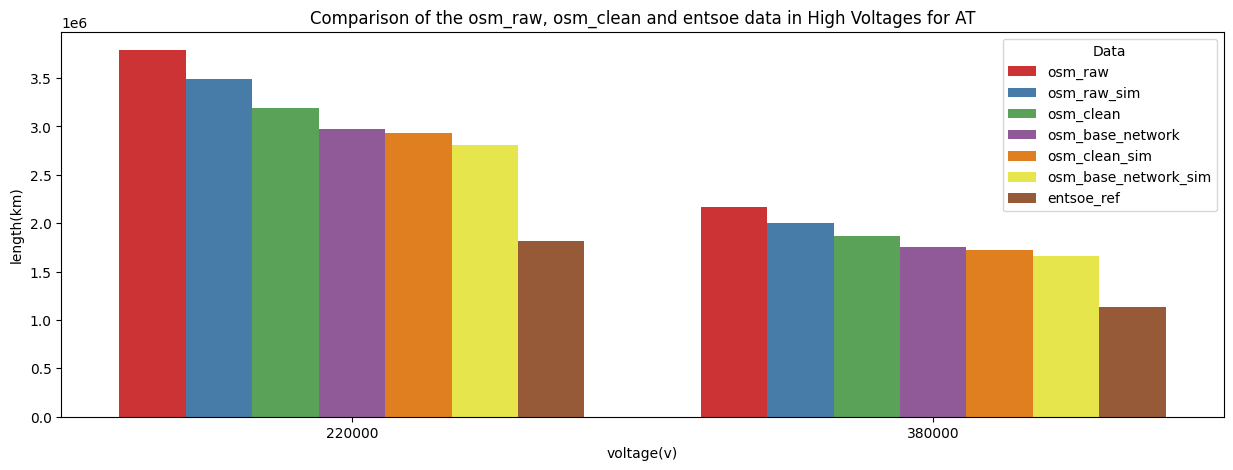

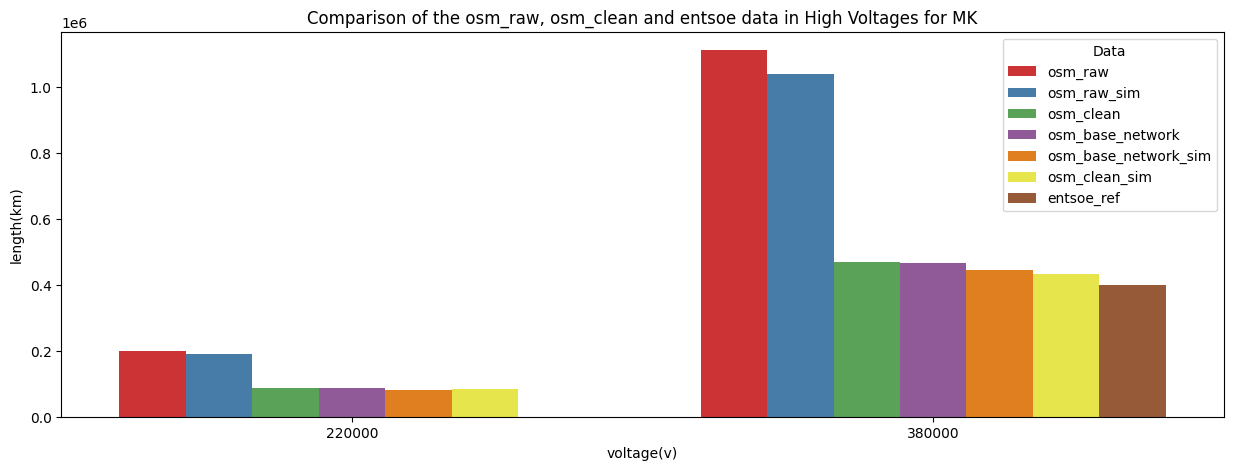

In [27]:
simplified_plot(df_at, 'at')
simplified_plot(df_mk, 'mk')

## CRS Check

Todo: CRS check against google maps data


# Conclusion

From the analysis, it is observed that osm-data is more accurate compared to entsoe-data. osm-data uses lower simplification compared to entsoe-data which makes it more accurate. 

Following the analysis done in this notebook, validation should happen with the CSV's (base_network/all_lines_build_network.csv) for OSM data and not the `elec.nc` because in `elec.nc`, all voltage level have been rebased to 220kV, 300kV and 380kV.